In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\igriz\AppData\Local\Temp\ipykernel_18480\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [7]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv(r"C:\Users\igriz\Documents\BOOTCAMP 2024\WEEK 7\DAY1\lab-natural-language-processing-main\lab-natural-language-processing-main\data\kg_train.csv" ,encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [9]:
from sklearn.model_selection import train_test_split
# Example: Assuming 'target_column' is the name of your target variable
X = data.drop('label', axis=1)  # Features (all columns except the target)
y = data['label']  # Target (only the target column)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data Preprocessing

In [11]:
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igriz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [13]:
import re 
from nltk.stem.snowball import SnowballStemmer

# Function to clean HTML
def clean_html(text):
    # Remove inline JavaScript/CSS
    text = re.sub(r'<script.*?>.*?</script>', '', text, flags=re.DOTALL)
    text = re.sub(r'<style.*?>.*?</style>', '', text, flags=re.DOTALL)
    
    # Remove HTML comments
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    
    # Remove remaining HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    return text

29     regard mr nelson smithkind repli privat email ...
535          abl reach oscar suppos send pdb 11 u receiv
695    huma abedin b6im check pat 50k work jack jake ...
557                            announc monday cant today
836    bank africaag san pedro14 bp 1210 san pedro 14...
Name: cleaned_text, dtype: object
521    dear sir2c wish go offer consid partner2ei mr2...
737    take mind balkan second see ã¢ââ great plug ...
740                                  pls keep updat come
660    christ bethel hospital11 rue aboboteabidjanivo...
411    sbwhoeopfriday februari 5 2010 711 amhr bravo ...
Name: cleaned_text, dtype: object


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

## Now let's work on removing stopwords
Remove the stopwords.

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igriz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\igriz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [18]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()

     # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in text.split() if word not in stop_words])

     # Apply lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

# Apply cleaning and preprocessing to the text data
X_train['cleaned_text'] = X_train['text'].apply(clean_html).apply(preprocess_text)
X_test['cleaned_text'] = X_test['text'].apply(clean_html).apply(preprocess_text)

# Verify the cleaned data
print(X_train['cleaned_text'].head())
print(X_test['cleaned_text'].head())

29     regard mr nelson smithkindly reply private ema...
535           able reach oscar supposed send pdb receive
695    huma abedin bim checking pat work jack jake re...
557                          announced monday cant today
836    bank africaagence san pedro bp san pedro cote ...
Name: cleaned_text, dtype: object
521    dear sirc wish go offer consider partnerei mre...
737    take mind balkan second see great plug global ...
740                               pls keep update coming
660    christ bethel hospital rue aboboteabidjanivory...
411    sbwhoeopfriday february amhre bravo brava issu...
Name: cleaned_text, dtype: object


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

data = data.head(1000)
data.fillna("", inplace=True)

# Split into ham and spam messages
ham_messages = data[data['label'] == 0]['text']  # Assuming 0 represents ham
spam_messages = data[data['label'] == 1]['text']  # Assuming 1 represents spam

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform ham messages
ham_bow = vectorizer.fit_transform(ham_messages)
ham_word_counts = pd.DataFrame(ham_bow.toarray(), columns=vectorizer.get_feature_names_out())
ham_top_10 = ham_word_counts.sum().sort_values(ascending=False).head(10)

# Fit and transform spam messages
spam_bow = vectorizer.fit_transform(spam_messages)
spam_word_counts = pd.DataFrame(spam_bow.toarray(), columns=vectorizer.get_feature_names_out())
spam_top_10 = spam_word_counts.sum().sort_values(ascending=False).head(10)

# Display the top 10 words
print("Top 10 words in Ham Messages:")
print(ham_top_10)

print("\nTop 10 words in Spam Messages:")
print(spam_top_10)

Top 10 words in Ham Messages:
the     1773
to      1065
and      833
of       791
in       616
that     414
is       385
for      369
on       329
you      311
dtype: int64

Top 10 words in Spam Messages:
the     7046
to      5593
of      4984
and     3985
in      3289
you     3229
this    2675
my      2143
your    2078
for     2030
dtype: int64


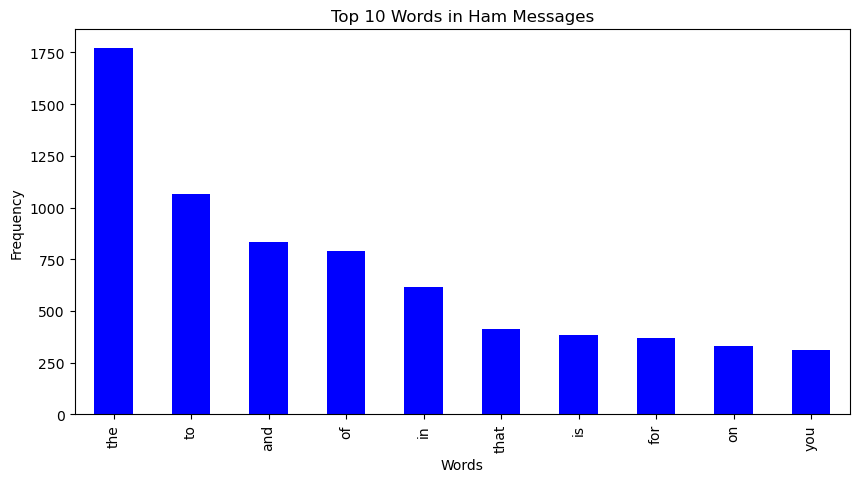

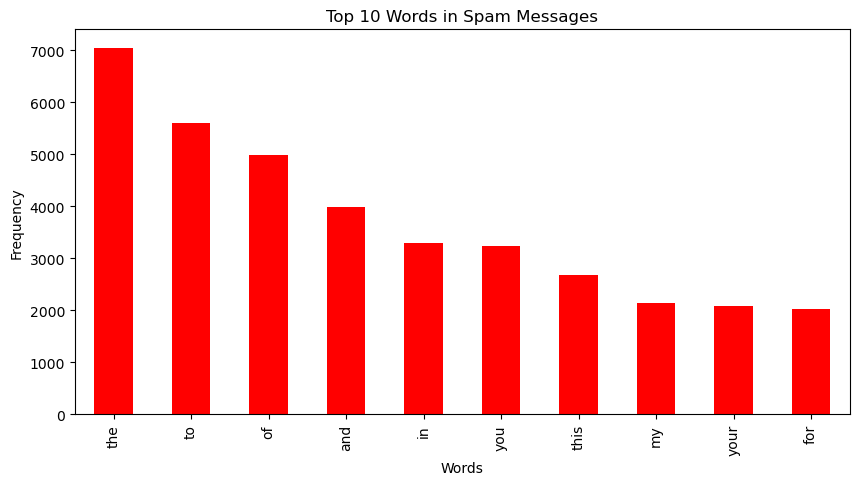

In [21]:
import matplotlib.pyplot as plt

# Plot top 10 words in ham messages
plt.figure(figsize=(10, 5))
ham_top_10.plot(kind='bar', color='blue')
plt.title('Top 10 Words in Ham Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Plot top 10 words in spam messages
plt.figure(figsize=(10, 5))
spam_top_10.plot(kind='bar', color='red')
plt.title('Top 10 Words in Spam Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## Extra features

In [23]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

In [24]:
data_train['preprocessed_text'] = data_train['text'].apply(preprocess_text).apply(clean_html)
data_val['preprocessed_text'] = data_val['text'].apply(preprocess_text).apply(clean_html)

# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

,text,label,preprocessed_text,money_mark,suspicious_words,text_len
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,regard mr nelson smithkindly reply private ema...,1,0,75
535,I have not been able to reach oscar this am. W...,0,able reach oscar supposed send pdb receive,1,0,42
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,huma abedin bim checking pat work jack jake re...,1,0,79
557,I can have it announced here on Monday - can't...,0,announced monday cant today,1,0,27
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,bank africaagence san pedro bp san pedro cote ...,1,1,1067


## How would work the Bag of Words with Count Vectorizer concept?

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data
bow_matrix = vectorizer.fit_transform(data_train)

# Vocabulary
print("Vocabulary:", vectorizer.vocabulary_)

# Bag of Words Matrix (Dense Format)
print("BoW Matrix (dense):\n", bow_matrix.toarray())

Vocabulary: {'text': 4, 'label': 0, 'preprocessed_text': 2, 'money_mark': 1, 'suspicious_words': 3, 'text_len': 5}
BoW Matrix (dense):
 [[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]]


## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [52]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = vectorizer.fit_transform(data_train)

# Print the shape of the vectorized dataset
print("Shape of TF-IDF Matrix:", tfidf_matrix.shape)

# Optional: Print the feature names (vocabulary)
print("Feature Names:", vectorizer.get_feature_names_out())


Shape of TF-IDF Matrix: (6, 6)
Feature Names: ['label' 'money_mark' 'preprocessed_text' 'suspicious_words' 'text'
 'text_len']


## And the Train a Classifier?

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(data_train['preprocessed_text'])
X_val = vectorizer.transform(data_val['preprocessed_text'])

# Get labels
y_train = data_train['label']
y_val = data_val['label']
# Train a Logistic Regression classifier
classifier = LogisticRegression(class_weight='balanced', random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_val_pred = classifier.predict(X_val)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, zero_division=0))


Validation Accuracy: 0.965

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       125
           1       1.00      0.91      0.95        75

    accuracy                           0.96       200
   macro avg       0.97      0.95      0.96       200
weighted avg       0.97      0.96      0.96       200



### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [32]:
# Your code